# Analyzing Gene Expression and Survival Outcomes in Breast Cancer

### Project Introduction
This notebook presents a comprehensive survival analysis of breast cancer patients using data from The Cancer Genome Atlas (TCGA-BRCA) cohort. The primary objective is to identify genomic predictors of patient survival by integrating high-dimensional RNA-sequencing data with clinical information.

The analysis follows a multi-step methodology:

1. **Exploratory Survival Analysis**: A baseline survival curve for the entire cohort is established using the Kaplan-Meier estimator.

2. **Multivariate Survival Modeling**: A Cox Proportional-Hazards model is built using clinical and biological variables (Age, Race, and ESR1 gene expression) to assess their individual impact on survival.

3. **High-Dimensional Feature Selection**: To navigate the challenge of analyzing ~60,000 genes, feature selection is employed. This involves an initial unsupervised variance filter followed by a LASSO (L1) penalized Cox regression to select a sparse set of the most impactful genes.

4. **Model Validation and Interpretation**: The final set of selected genes is validated in a standard Cox model to derive unbiased hazard ratios and p-values, and the well-known ESR1 gene's exclusion by the LASSO model is investigated.

The ultimate goal is to produce an interpretable model that uncovers a potential gene signature associated with patient survival in breast cancer.

--- 

### Table of Contents

1. [Imports](#imports)
2. [Constants & Data](#constants)
3. [Estimate the Survival Function using Kaplan-Meier](#kaplan_meier)
4. [Univariate Analysis: Impact of ESR1 Expression](#survival_analysis)
5. [Multivariate Cox Regression](#cox)
6. [Most predictive gene expression](#most_predictive)
7. [Why is ESR1 Filtered Away?](#esr1_filtered)
8. [Summary](#summary)


---

### 1. Imports <a class="anchor" id="imports"></a>

In [1]:
import os
from pathlib import Path
from typing import Tuple 

from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test
from lifelines import CoxPHFitter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn import set_config
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder

from sksurv.linear_model import CoxPHSurvivalAnalysis
from sksurv.nonparametric import kaplan_meier_estimator

from statsmodels.stats.outliers_influence import variance_inflation_factor

### 2. Constants & Data Import <a class="anchor" id="constants"></a>


The following data files will need to be downloaded from [The Cancer Genome Atlas]((https://xenabrowser.net/datapages/?cohort=GDC%20TCGA%20Breast%20Cancer%20(BRCA)&removeHub=https%3A%2F%2Fxena.treehouse.gi.ucsc.edu%3A443))

* **gene expression RNAseq: STAR - FPKM-UQ**: Expression of 58 thousand genes.
* **phenotype: survival data**: Clinical data from each patient

The notebook expects both tsv files to be placed in the `data/` folder.

In [2]:
ROOT = Path(os.getcwd()).parents[0]

DATA_PATH = os.path.join(ROOT, "data", "TCGA-BRCA.star_fpkm-uq.tsv")
CLINICAL_DATA_PATH = os.path.join(ROOT, "data", "TCGA-BRCA.clinical.tsv")

In [3]:
df = pd.read_csv(DATA_PATH, sep="\t", index_col=0).drop_duplicates()
df_clinical = pd.read_csv(CLINICAL_DATA_PATH, sep="\t", index_col=0).drop_duplicates()

display(df.head())
print(f"Number of genes: {df.shape[0]}")
print(f"Number of samples: {df.shape[1]}")
display(df_clinical.head())
print(f"Number of clinical samples: {df_clinical.shape[0]}")
print(f"Number of clinical features: {df_clinical.shape[1]}")

,TCGA-D8-A146-01A,TCGA-AQ-A0Y5-01A,TCGA-C8-A274-01A,TCGA-BH-A0BD-01A,TCGA-B6-A1KC-01B,TCGA-AC-A62V-01A,TCGA-AO-A0J5-01A,TCGA-BH-A0B1-01A,TCGA-A2-A0YM-01A,TCGA-AO-A03N-01B,...,TCGA-E2-A1IG-01A,TCGA-E9-A1NA-01A,TCGA-D8-A1JP-01A,TCGA-AR-A252-01A,TCGA-D8-A1XL-01A,TCGA-BH-A0EI-01A,TCGA-E2-A1IO-01A,TCGA-E2-A15R-01A,TCGA-B6-A0IP-01A,TCGA-A1-A0SN-01A
Ensembl_ID,,,,,,,,,,,,,,,,,,,,,
ENSG00000000003.15,3.767708,2.132741,4.768010,3.049735,3.009311,2.262163,2.929999,4.243105,4.231540,3.126461,...,3.083077,2.463256,3.263365,3.203264,3.653874,4.470745,4.214863,1.175109,5.008083,1.993783
ENSG00000000005.6,1.759454,0.146003,0.000000,1.071763,0.185993,0.308594,0.467071,0.121281,0.124196,0.000000,...,0.038015,0.045024,0.023184,1.922426,0.000000,0.104739,0.224658,0.127501,0.165172,0.015783
ENSG00000000419.13,4.920541,5.284151,5.051694,4.618797,4.852973,5.364065,3.958935,5.171995,4.771500,5.550193,...,4.556411,4.596321,5.213518,4.374831,5.696970,5.234413,4.876325,4.975405,4.569892,6.213147
ENSG00000000457.14,2.612588,2.428544,3.356299,2.680774,2.381671,1.128095,2.787265,2.398214,1.637378,1.876527,...,2.257493,2.141498,3.250295,2.203232,2.196827,2.030407,2.303109,2.895225,2.681697,2.431356
ENSG00000000460.17,1.363395,1.158337,2.458172,2.494236,1.565841,1.249809,1.221939,1.857344,2.197771,1.396050,...,1.223670,1.222805,2.184534,1.291250,1.736778,1.531219,1.123070,1.955015,1.791314,1.716025


Number of genes: 58049
Number of samples: 1226


,id,disease_type,case_id,submitter_id,primary_site,alcohol_history.exposures,race.demographic,gender.demographic,ethnicity.demographic,vital_status.demographic,...,days_to_collection.samples,initial_weight.samples,preservation_method.samples,pathology_report_uuid.samples,oct_embedded.samples,specimen_type.samples,days_to_sample_procurement.samples,is_ffpe.samples,tissue_type.samples,annotations.samples
sample,,,,,,,,,,,,,,,,,,,,,
TCGA-BH-A0W3-01A,3c612e12-6de8-44fa-a095-805c45474821,Ductal and Lobular Neoplasms,3c612e12-6de8-44fa-a095-805c45474821,TCGA-BH-A0W3,Breast,Not Reported,white,female,not hispanic or latino,Alive,...,85.0,120.0,OCT,801A4E2F-E26E-424F-BF42-CD0D9CD62BCE,True,Solid Tissue,NaN,False,Tumor,NaN
TCGA-AR-A24V-01A,3cb06c7a-f2a8-448b-91a8-dd201bbf2ddd,Ductal and Lobular Neoplasms,3cb06c7a-f2a8-448b-91a8-dd201bbf2ddd,TCGA-AR-A24V,Breast,Not Reported,white,female,not hispanic or latino,Alive,...,1720.0,400.0,OCT,468CD293-C9F7-43C6-A40A-18FCDD22F6AA,True,Solid Tissue,NaN,False,Tumor,NaN
TCGA-E9-A1NE-01A,3d676bba-154b-4d22-ab59-d4d4da051b94,Ductal and Lobular Neoplasms,3d676bba-154b-4d22-ab59-d4d4da051b94,TCGA-E9-A1NE,Breast,Not Reported,white,female,not hispanic or latino,Alive,...,31.0,280.0,OCT,CF6E29A2-FAE6-45BB-B625-33877887A89E,True,Solid Tissue,NaN,False,Tumor,NaN
TCGA-E9-A1NE-11A,3d676bba-154b-4d22-ab59-d4d4da051b94,Ductal and Lobular Neoplasms,3d676bba-154b-4d22-ab59-d4d4da051b94,TCGA-E9-A1NE,Breast,Not Reported,white,female,not hispanic or latino,Alive,...,31.0,830.0,OCT,NaN,True,Solid Tissue,NaN,False,Normal,NaN
TCGA-AC-A8OQ-01A,dfaabd03-2d40-4422-b210-caf112ff4229,Ductal and Lobular Neoplasms,dfaabd03-2d40-4422-b210-caf112ff4229,TCGA-AC-A8OQ,Breast,Not Reported,black or african american,female,not hispanic or latino,Alive,...,742.0,100.0,Unknown,FFA6F9F3-71C1-4AF9-B9F7-0466550EBC90,False,Solid Tissue,NaN,False,Tumor,NaN


Number of clinical samples: 1255
Number of clinical features: 84


### 3. Estimate the Survival Function using Kaplan-Meier <a class="anchor" id="kaplan_meier"></a>

To calculate the Kaplan Meier survival curve, we need to define the `event` and `duration` values for each patient.

**Event**: The `vital_status.demographic` column contains values of either Alive or Dead. We define here the event as those patients labeled Dead

**Duration**: Here, the `days_to_death.demographic` columns represent the days from initial diagnosis to death. This represents the time value for patients who had the event. The `days_to_last_follow_up.diagnosis` column represents the number of days from initial diagnosis to the last known follow up appointment, representing the time value for patients who are censored.

In [4]:
display(
    df_clinical[df_clinical["days_to_death.demographic"].isna()][
        ["days_to_death.demographic", "days_to_last_follow_up.diagnoses"]
    ].head(3)
)
display(
    df_clinical[~df_clinical["days_to_death.demographic"].isna()][
        ["days_to_death.demographic", "days_to_last_follow_up.diagnoses"]
    ].head(3)
)

,days_to_death.demographic,days_to_last_follow_up.diagnoses
sample,,
TCGA-BH-A0W3-01A,NaN,728.0
TCGA-AR-A24V-01A,NaN,3203.0
TCGA-E9-A1NE-01A,NaN,1088.0


,days_to_death.demographic,days_to_last_follow_up.diagnoses
sample,,
TCGA-BH-A203-01A,1174.0,NaN
TCGA-BH-A203-11A,1174.0,NaN
TCGA-AC-A2FM-11B,792.0,NaN


Create an event and duration column following the standard Kaplan-Meier conventions.

In [5]:
df_clinical["event"] = (
    (df_clinical['vital_status.demographic'] == 'Dead').astype(int)
)
df_clinical["duration"] = df_clinical.apply(
    lambda x: x["days_to_death.demographic"]
    if x["event"]
    else x["days_to_last_follow_up.diagnoses"],
    axis=1,
)
df_clinical["duration"] = df_clinical["duration"] / 365  # Convert to years
df_clinical = df_clinical[df_clinical["duration"] >= 0]  # Remove negative durations
df_clinical[["event", "duration"]].head(3)

,event,duration
sample,,
TCGA-BH-A0W3-01A,0,1.994521
TCGA-AR-A24V-01A,0,8.775342
TCGA-E9-A1NE-01A,0,2.980822


Visualize the distribution of censored patients as a function of survival time.

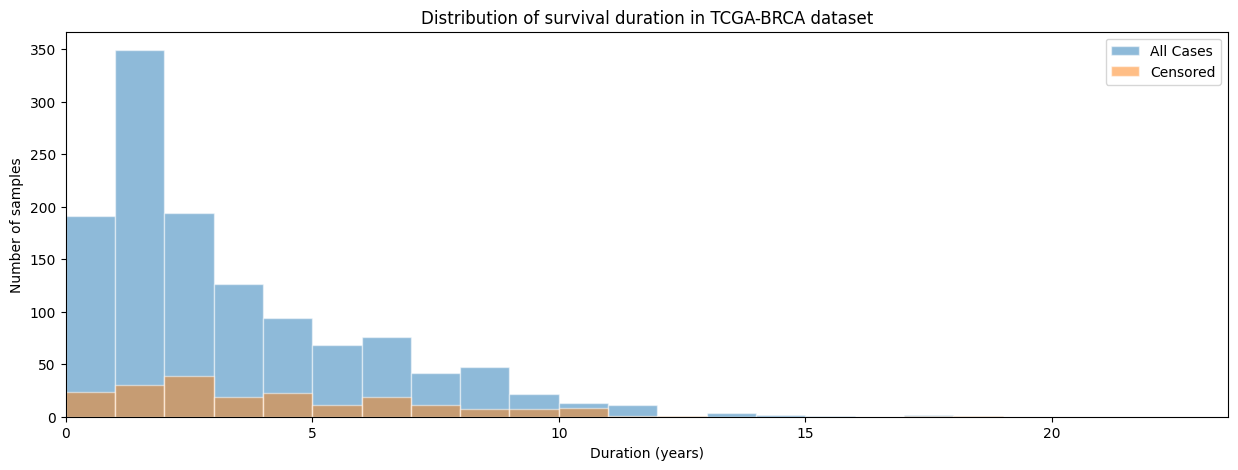

In [6]:
_, axes = plt.subplots(figsize=(15, 5))

plt.hist(
    df_clinical["duration"],
    bins=np.arange(0, 20, 1),
    alpha=0.5,
    label="All Cases",
    edgecolor="w",
)
plt.hist(
    df_clinical[df_clinical["event"] == 1]["duration"],
    bins=np.arange(0, 20, 1),
    alpha=0.5,
    label="Censored",
    edgecolor="w",
)
plt.xlim(0, df_clinical["duration"].max())
plt.xlabel("Duration (years)")
plt.ylabel("Number of samples")
plt.legend()
plt.title("Distribution of survival duration in TCGA-BRCA dataset");

Use the lifelines library to generate the survival curve.

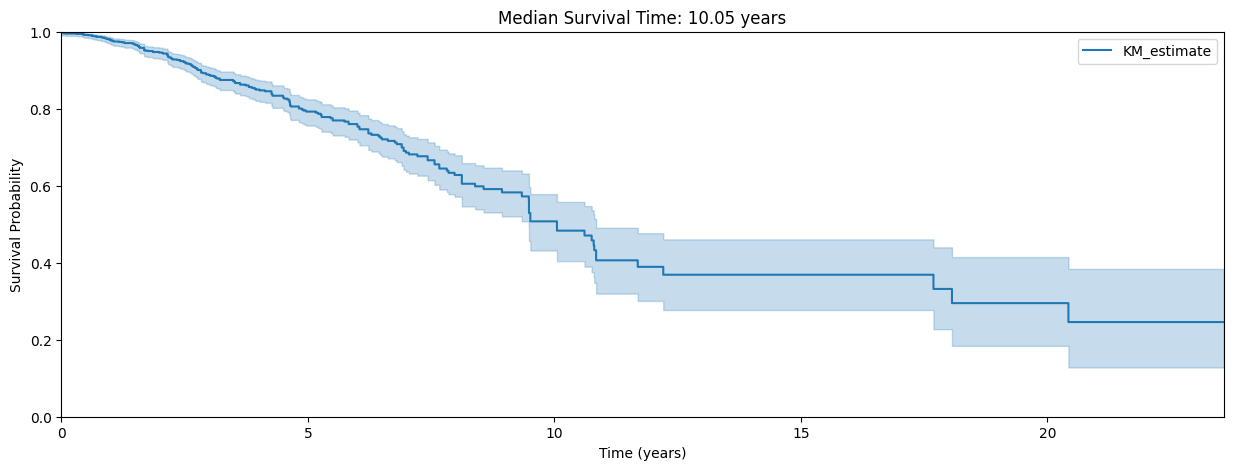

In [7]:
kmf = KaplanMeierFitter()

df_clinical = df_clinical.dropna(subset=["event", "duration"])
kmf.fit(df_clinical["duration"], event_observed=df_clinical["event"])

_, axes = plt.subplots(figsize=(15, 5))
kmf.plot_survival_function()
plt.title(f"Median Survival Time: {kmf.median_survival_time_:.2f} years")
plt.xlabel("Time (years)")
plt.ylabel("Survival Probability")
plt.xlim(0, df_clinical["duration"].max())
plt.ylim(0, 1);

The sci-kit survival model also provides a convenient method to estimating the Kaplan Meier survival.

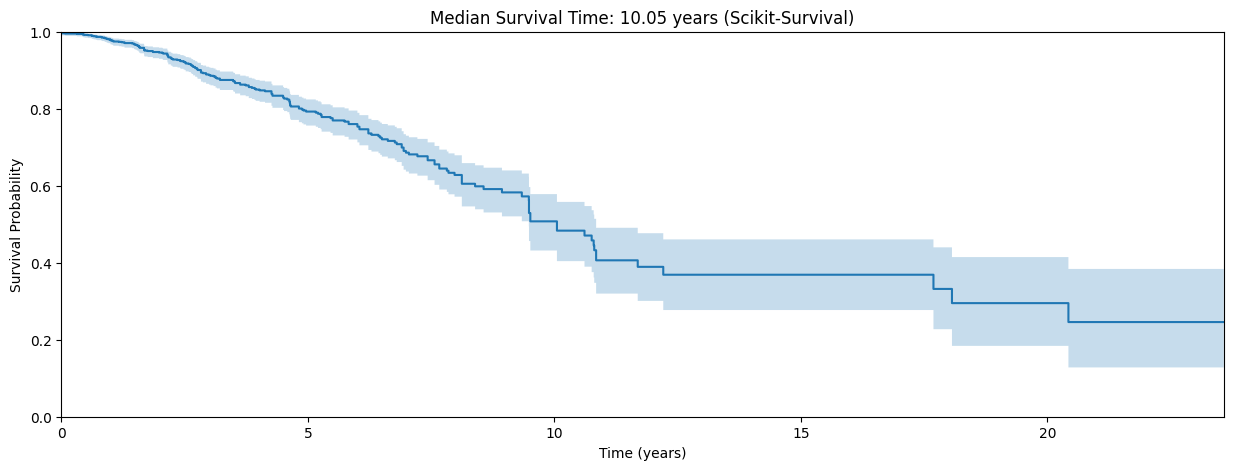

In [8]:
time, survival_prob, conf_int = kaplan_meier_estimator(
    df_clinical["event"].astype(bool), df_clinical["duration"], conf_type="log-log"
)

_, axes = plt.subplots(figsize=(15, 5))
plt.step(time, survival_prob, where="post")
plt.fill_between(time, conf_int[0], conf_int[1], alpha=0.25, step="post")
plt.title(f"Median Survival Time: {kmf.median_survival_time_:.2f} years (Scikit-Survival)")
plt.xlabel("Time (years)")
plt.ylabel("Survival Probability")
plt.xlim(0, df_clinical["duration"].max())
plt.ylim(0, 1);

**Observations**: 
- The Kaplan-Meier plot shows that the median survival time for this cohort is approximately 10.05 years. 
- The survival probability at the 5 year mark is reasonably high, appearing to be around 80-85%. This suggests a generally favorable prognosis for a large portion of patients in the first five years
- The curve is steepest during the first 10 years. This indicates that the highest rate of death events occurs within the first decade after diagnosis.  Although caution should be applied to data after 5 years since the number of patients in this regime is low.

### 4. Univariate Analysis: Impact of ESR1 Expression <a class="anchor" id="survival_analysis"></a>

Here, the effect of a single, well-known biomarker, ESR1 (Estrogen Receptor 1), on patient survival is investigated. The patients are stratified into "High" and "Low" ESR1 expression groups based on the median expression and a log-rank test is used to compare their survival curves.

In [9]:
ESR1_Ensembl_ID = "ENSG00000091831"

df.index = [id_.split(".")[0] for id_ in df.index]
esr_expression = df.loc[ESR1_Ensembl_ID]

Visualize the distribution of ESR1 expression among the entire cohort.

Text(0, 0.5, 'Frequency')

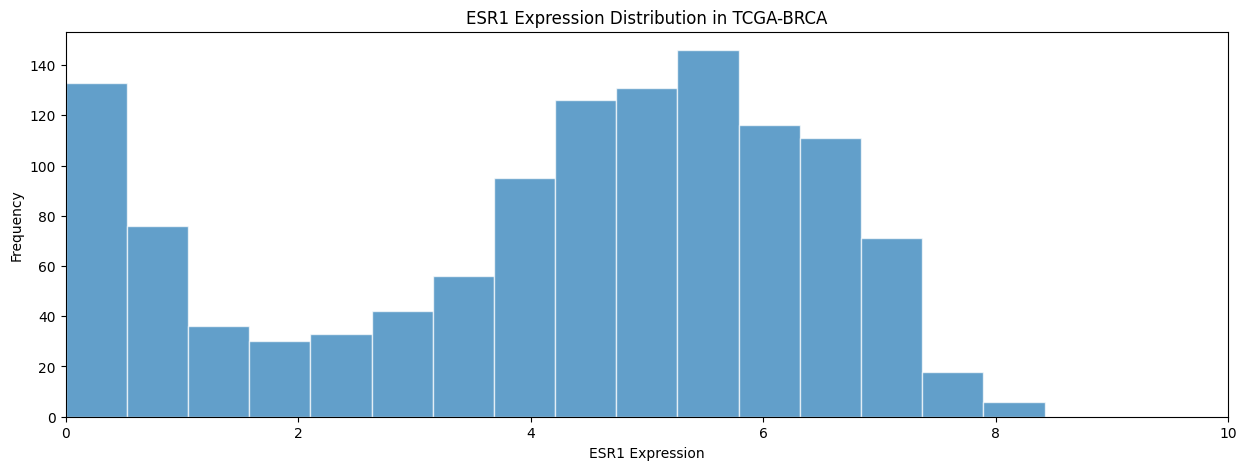

In [10]:
_, axes = plt.subplots(figsize=(15, 5))

axes.hist(
    esr_expression,
    bins=np.linspace(0, 10, 20),
    edgecolor="white",
    alpha=0.7,
)

axes.set_xlim(0, 10)

plt.title("ESR1 Expression Distribution in TCGA-BRCA")
plt.xlabel("ESR1 Expression")
plt.ylabel("Frequency")

Merge ESR1 with Clinical Data

In [11]:
df_clinical = df_clinical.merge(esr_expression, left_index=True, right_index=True)
above_median_expression = df_clinical[ESR1_Ensembl_ID] > esr_expression.median()

In [12]:
results = logrank_test(
    durations_A=df_clinical[~above_median_expression]["duration"],
    event_observed_A=df_clinical[~above_median_expression]["event"],
    label_A="Low ESR1 Expression",
    durations_B=df_clinical[above_median_expression]["duration"],
    event_observed_B=df_clinical[above_median_expression]["event"],
    label_B="High ESR1 Expression",
)

results.print_summary()

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
           label_A = Low ESR1 Expression
           label_B = High ESR1 Expression
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           0.58 0.45      1.16

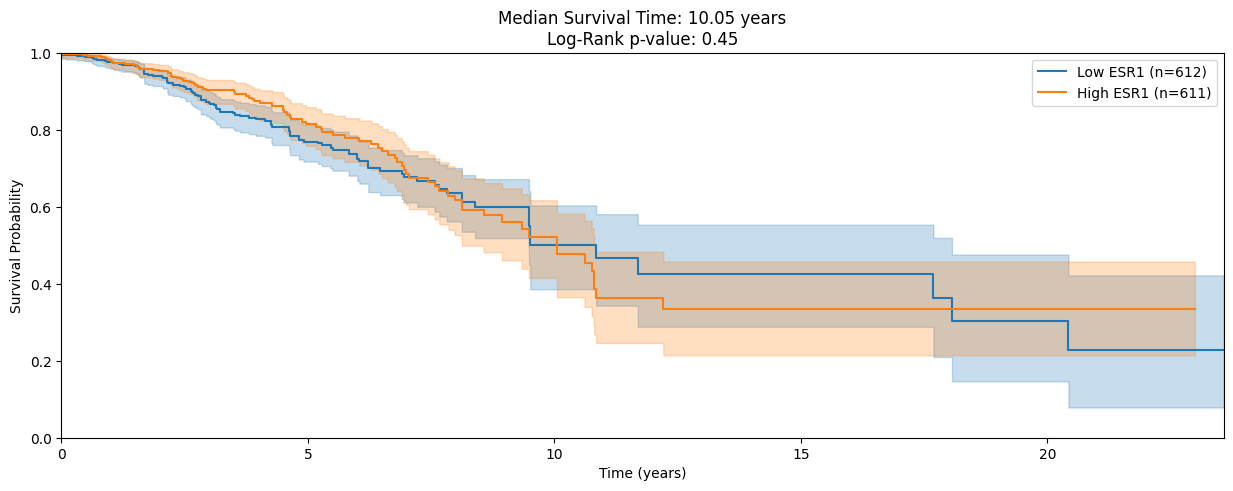

In [13]:
kmf = KaplanMeierFitter()

df_clinical = df_clinical.dropna(subset=["event", "duration"])
kmf.fit(
    df_clinical[~above_median_expression]["duration"],
    event_observed=df_clinical[~above_median_expression]["event"],
    label="Low ESR1 (n=%d)" % df_clinical[~above_median_expression].shape[0],
)

_, axes = plt.subplots(figsize=(15, 5))
kmf.plot_survival_function(ax=axes)

kmf.fit(
    df_clinical[above_median_expression]["duration"],
    event_observed=df_clinical[above_median_expression]["event"],
    label="High ESR1 (n=%d)" % df_clinical[above_median_expression].shape[0],
)

kmf.plot_survival_function(ax=axes)
plt.title(
    f"Median Survival Time: {kmf.median_survival_time_:.2f} years\nLog-Rank p-value: {results.p_value:.2f}"
)
plt.xlabel("Time (years)")
plt.ylabel("Survival Probability")
plt.xlim(0, df_clinical["duration"].max())
plt.ylim(0, 1);

**Observation**: The log-rank test yields a p-value greater than 0.05. In this univariate analysis, there is no statistically significant difference in survival between patients with "high" versus "low" ESR1 expression. This suggests that other factors may be confounding its effect.

### 5. Multivariate Cox Regression <a class="anchor" id="cox"></a>

We now build a multivariate Cox Proportional-Hazards model to assess the impact of ESR1 expression while controlling for other clinical variables like age and race.

In [14]:
df_clinical["race.demographic"].value_counts(normalize=True)

race.demographic
white                               0.715454
black or african american           0.154538
not reported                        0.078496
asian                               0.050695
american indian or alaska native    0.000818
Name: proportion, dtype: float64

In [15]:
cols_to_check = [
    # 'alcohol_history.exposures', # alcohol history is Not Reported for all samples
    "race.demographic",
    "age_at_index.demographic",
    ESR1_Ensembl_ID,
]

data_x = df_clinical[["event", "duration"] + cols_to_check]
encoder = OneHotEncoder()
one_hot_encoded = encoder.fit_transform(data_x[["race.demographic"]])

one_hot_df = pd.DataFrame(
    one_hot_encoded.toarray(),
    columns=encoder.get_feature_names_out(["race.demographic"]),
    index=data_x.index,
)
data_x = pd.concat([data_x, one_hot_df], axis=1)

# # Optionally, drop the original categorical column
data_x.drop(
    columns=[
        "race.demographic",
        "race.demographic_white",  # remove white as the reference group
        "race.demographic_american indian or alaska native",  # remove american indian or alaska native because it has very few samples
    ],
    inplace=True,
)

data_x.head()

,event,duration,age_at_index.demographic,ENSG00000091831,race.demographic_asian,race.demographic_black or african american,race.demographic_not reported
TCGA-BH-A0W3-01A,0,1.994521,58.0,6.923400,0.0,0.0,0.0
TCGA-AR-A24V-01A,0,8.775342,52.0,4.742303,0.0,0.0,0.0
TCGA-E9-A1NE-01A,0,2.980822,28.0,4.296817,0.0,0.0,0.0
TCGA-AC-A8OQ-01A,0,0.093151,72.0,0.615981,0.0,1.0,0.0
TCGA-AC-A23C-01A,0,1.602740,62.0,6.677587,0.0,0.0,0.0


In [16]:
data_y = data_x[["event", "duration"]].copy()

data_y["event"] = data_y["event"].astype(bool)
data_y["duration"] = data_y["duration"]

tuple_list = [tuple(row) for row in data_y.itertuples(index=False, name=None)]

structured_dtype = np.dtype([("Status", "?"), ("Survival_in_days", "<f8")])
data_y = np.array([tuple(row) for row in data_y.to_numpy()], dtype=structured_dtype)

Check for multi-coliniearity between features

In [17]:
X = data_x.drop(columns=["event", "duration"])
vif = pd.Series(
    [variance_inflation_factor(X.values, i) for i in range(X.shape[1])], index=X.columns
)
print(vif)

age_at_index.demographic                      5.482277
ENSG00000091831                               4.930789
race.demographic_asian                        1.055973
race.demographic_black or african american    1.216731
race.demographic_not reported                 1.128367
dtype: float64


Train the Cox Proportional Hazard model (from sk-survival) and determine the Hazard Ratios for each feature

In [18]:
set_config(display="text")  # displays text representation of estimators

estimator = CoxPHSurvivalAnalysis()
estimator.fit(data_x.drop(columns=["event", "duration"]), data_y)
pd.concat(
    [
        pd.Series(
            estimator.coef_, index=data_x.drop(columns=["event", "duration"]).columns
        )
        .rename("Coefficients")
        .round(3),
        pd.Series(
            np.exp(estimator.coef_),
            index=data_x.drop(columns=["event", "duration"]).columns,
        )
        .rename("Hazard Ratios")
        .round(3),
    ],
    axis=1,
)

,Coefficients,Hazard Ratios
age_at_index.demographic,0.038,1.039
ENSG00000091831,-0.084,0.919
race.demographic_asian,-0.245,0.783
race.demographic_black or african american,-0.229,0.796
race.demographic_not reported,-0.121,0.886


Takeaways from this model:
- Older folks are more likely to die, ie for every year increase in age, the patients risk of death increases by 3.8%
- The ESR1 Gene appears to be somewhat protective where for every unit increase in expression, the risk of death decreases by almost 10%
- The risk of death for a patient identified as black or african american is 31% lower than their white counterpart
- Interestingly, the asian population has the highest comparitive decrease in the inicidence of death however this subgroup comprises only 5% of the population. Check this result by calculating the p-value.

Use lifelines library to determine the p-value for the asian demographic coefficient to determine statistical significance of each feature.

In [19]:
cph = CoxPHFitter()
cph.fit(data_x, duration_col="duration", event_col="event")
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 1223 total observations, 1024 right-censored observations>
             duration col = 'duration'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 1223
number of events observed = 199
   partial log-likelihood = -1137.29
         time fit was run = 2025-06-24 21:35:49 UTC

---
                                            coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                                   
age_at_index.demographic                    0.04      1.04      0.01            0.03            0.05                1.03                1.05
ENSG00000091831                            -0.08      0.92      0.03           -0.15           -0.02                0.86                0.98
race.demographic_asian                     -0.24      0.78      0.59           -1.39            0.91                0.25                2.48
race.demographic_black or african american -0.23      0.80      0.20           -0.62            0.17                0.54                1.18
race.demographic_not reported              -0.12      0.89      0.39           -0.89            0.65                0.41                1.91

                                            cmp to     z      p  -log2(p)
covariate                                                                
age_at_index.demographic                      0.00  6.50 <0.005     33.50
ENSG00000091831                               0.00 -2.43   0.02      6.04
race.demographic_asian                        0.00 -0.41   0.68      0.56
race.demographic_black or african american    0.00 -1.14   0.26      1.96
race.demographic_not reported                 0.00 -0.31   0.76      0.40
---
Concordance = 0.67
Partial AIC = 2284.57
log-likelihood ratio test = 43.85 on 5 df
-log2(p) of ll-ratio test = 25.27

Takeaways given this closer look:
- 66% Concordance is better than a coin flip indicating some predictive signal.
- Overall log-likelihood ratio of 18.16 (corresponding to a p-value of < 0.001) indicates a statistically significant better predictor than a null model with no variables.
- The previous takeaways from Age and ESR1 expression are statistically significant (p-values <0.05 with 95% CI range not crossing 1)
- None of the race features turn out to be statstically significant with wildly large 95% CI ranges and high p-values

**Observation**: The multivariate model (Concordance = 0.66) reveals significant findings. After controlling for other factors, both age (HR=1.04, p<0.005) and ESR1 expression (HR=0.91, p=0.01) emerge as statistically significant predictors. This confirms that age is a risk factor, while higher ESR1 expression is a protective factor. No race category showed a significant difference in survival compared to the reference group.

### 6. Most predictive gene expression <a class="anchor" id="most_predictive"></a>

To identify the most predictive genes from the entire ~60,000-gene dataset, we employ a two-step process: an unsupervised variance filter followed by a LASSO-penalized Cox regression for feature selection.

In [20]:
df_gene = df.T
df_gene.shape

(1226, 58049)

There are almost 50x more genes than samples in this dataset. Pare down number of genes using a variance filter.

In [21]:
# Calculate variance and keep the top 1% of most variable genes
variance_filter = 0.01  # keep top <vairance_filter> % of genes with highest variance

variances = df_gene.var()
high_variance_genes = variances.nlargest(int(len(variances) * variance_filter)).index
df_gene_filt = df_gene[high_variance_genes]
df_gene_filt.shape

(1226, 580)

In [22]:
if ESR1_Ensembl_ID in df_gene_filt.columns:
    print("The estrogen receptor gene is present in the variance filtered dataset.")
else:
    print("The estrogen receptor gene is NOT present in the variance filtered dataset.")

The estrogen receptor gene is present in the variance filtered dataset.


Apply an L1 Penalty to determine the most predictive genes.

In [23]:
df_lasso = df_clinical[["duration", "event"]].merge(
    df_gene_filt, left_index=True, right_index=True
)

cph_lasso = CoxPHFitter(penalizer=0.01, l1_ratio=1.0)
cph_lasso.fit(df_lasso.round(2), duration_col="duration", event_col="event")

# cph_lasso.print_summary()

<lifelines.CoxPHFitter: fitted with 1223 total observations, 1024 right-censored observations>

Vizualize the hazard ratios for the high variance genes from our Lasso model.

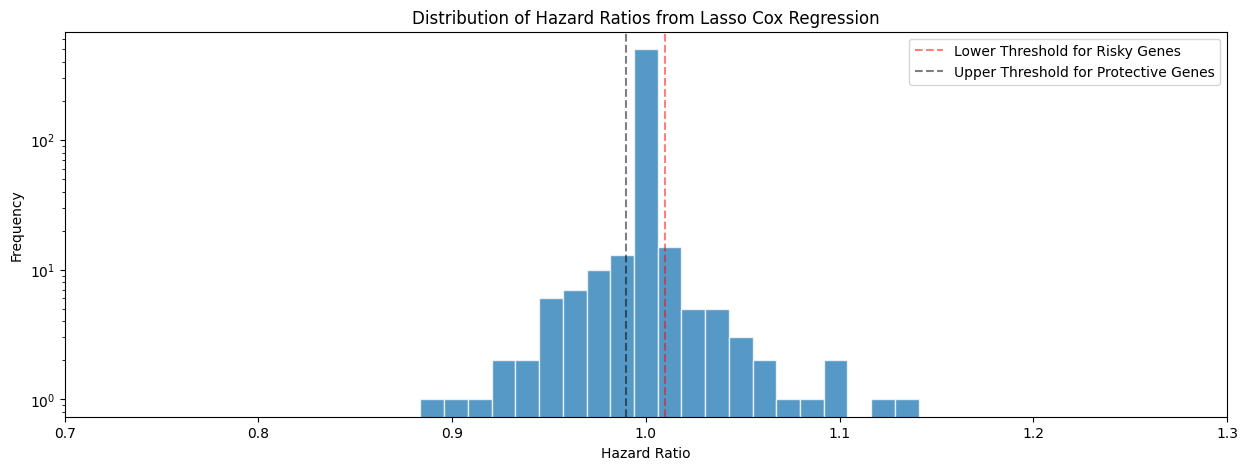

In [24]:
_, axes = plt.subplots(figsize=(15, 5))
cph_lasso.hazard_ratios_.hist(
    bins=np.linspace(0.7, 1.3, 50), edgecolor="w", grid=False, ax=axes, alpha=0.75
)
axes.axvline(
    1.01,
    color="red",
    linestyle="--",
    label="Lower Threshold for Risky Genes",
    alpha=0.5,
)
axes.axvline(
    0.99,
    color="k",
    linestyle="--",
    label="Upper Threshold for Protective Genes",
    alpha=0.5,
)

axes.set_xlabel("Hazard Ratio")
axes.set_ylabel("Frequency")
axes.set_title("Distribution of Hazard Ratios from Lasso Cox Regression")
axes.set_yscale("log")
axes.legend()
axes.set_xlim([0.7, 1.3]);

Select genes with a Hazard Ratio +/- a threshold around 1.

In [25]:
threshold = 0.01  # Hazard ratio threshold for selecting genes
# Select genes with hazard ratios +/- threshold from 1

lasso_results_df = cph_lasso.summary
selected_genes_list = lasso_results_df[
    (lasso_results_df["exp(coef)"] > 1 + threshold)
    | (lasso_results_df["exp(coef)"] < 1 - threshold)
].index.tolist()

df_selected_genes = df_gene_filt[selected_genes_list]
df_selected_genes.shape

(1226, 72)

In [26]:
if ESR1_Ensembl_ID in df_selected_genes.columns:
    print("The estrogen receptor gene is present in the Lasso filtered dataset.")
else:
    print("The estrogen receptor gene is NOT present in the Lasso filtered dataset.")

The estrogen receptor gene is NOT present in the Lasso filtered dataset.


In [27]:
set_config(display="text")  # displays text representation of estimators

estimator = CoxPHSurvivalAnalysis()
estimator.fit(data_x.drop(columns=["event", "duration"]), data_y)
pd.concat(
    [
        pd.Series(
            estimator.coef_, index=data_x.drop(columns=["event", "duration"]).columns
        )
        .rename("Coefficients")
        .round(3),
        pd.Series(
            np.exp(estimator.coef_),
            index=data_x.drop(columns=["event", "duration"]).columns,
        )
        .rename("Hazard Ratios")
        .round(3),
    ],
    axis=1,
)

,Coefficients,Hazard Ratios
age_at_index.demographic,0.038,1.039
ENSG00000091831,-0.084,0.919
race.demographic_asian,-0.245,0.783
race.demographic_black or african american,-0.229,0.796
race.demographic_not reported,-0.121,0.886


Fit a standard, unpenalized Cox model using ONLY the genes selected by LASSO.

In [28]:
df_final = df_clinical[["duration", "event"]].merge(
    df_selected_genes, left_index=True, right_index=True
)

cph_inference = CoxPHFitter()
cph_inference.fit(df_final.round(2), duration_col="duration", event_col="event")

final_results = cph_inference.summary

# Filter for genes with a p-value < 0.05
significant_genes = final_results[final_results["p"] < 0.05]

print(f"{significant_genes.shape[0]} significant genes found with p-value < 0.05")

29 significant genes found with p-value < 0.05


### 7. Analysis: Why Was ESR1 Excluded by LASSO? <a class="anchor" id="esr1_filtered"></a>

The ESR1 gene is a cornerstone of breast cancer biology, and its importance is directly linked to patient outcomes. So why has it been filtered away by the Lasso method? The primary hypothesis is that its predictive information is redundant, captured either by 
1. a single gene that is highly correlated with its expression
or 
2. a combination of other genes selected by the model

Check the correlation between the expression of the ESR1 gene and other genes in our filtered dataset.

In [29]:
df_gene[df_selected_genes.columns.tolist() + [ESR1_Ensembl_ID]].corr().abs()[ESR1_Ensembl_ID].sort_values(ascending=False)[:10]

ENSG00000091831    1.000000
ENSG00000186868    0.677120
ENSG00000175356    0.672177
ENSG00000164434    0.532473
ENSG00000084628    0.530581
ENSG00000105707    0.520066
ENSG00000197977    0.514084
ENSG00000133048    0.497549
ENSG00000130707    0.495263
ENSG00000188505    0.484646
Name: ENSG00000091831, dtype: float64

Define a helper function to calculate the slope of the linear regression between two arrays.

In [30]:
def get_linear_reg(x_values: np.ndarray, y_values: np.ndarray) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Perform linear regression on the given x and y values and return the regression line and slope.

    Args:
        x_values (np.ndarray): A 1D array of x-values for the regression.
        y_values (np.ndarray): A 1D array of y-values for the regression.

    Returns:
        Tuple[np.ndarray, np.ndarray, np.ndarray]: 
            - x_range: A 2D array of x-values for the regression line.
            - y_range: A 2D array of predicted y-values for the regression line.
            - slope: A 1D array containing the slope of the regression line.
    """
    # Create a linear regression model
    model = LinearRegression()
    model.fit(x_values.reshape(-1, 1), y_values.reshape(-1, 1))

    # Get the slope
    slope = model.coef_[0]

    # Create the regression line
    x_range = np.linspace(x_values.min(), x_values.max(), 100).reshape(-1, 1)
    y_range = model.predict(x_range)

    return x_range, y_range, slope

There is some correlation between the expression of the ESR1 gene and a few selected genes, however the maximum correlation is modest, never exceeding 0.67.

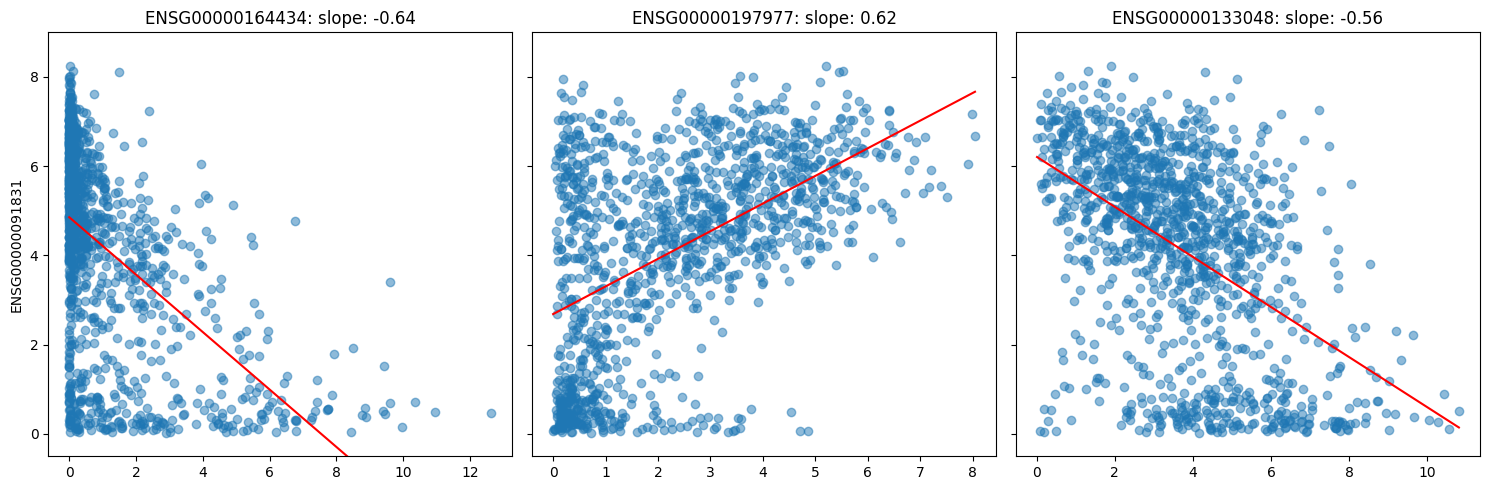

In [31]:
# List of genes to compare with ESR1
genes_to_compare = df_gene[significant_genes.index.tolist() + [ESR1_Ensembl_ID]].corr().abs()[ESR1_Ensembl_ID].sort_values(ascending=False)[1:4].index.tolist()

# Extract ESR1 expression data
esr1_expression = df_gene[ESR1_Ensembl_ID]

# Create scatter plots
_, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

for idx, gene in enumerate(genes_to_compare):
    x_values, y_values = df_gene[gene], esr1_expression
    axes[idx].scatter(x_values, y_values,  alpha=0.5) 
    x_fit, y_fit, slope = get_linear_reg(x_values.values, y_values.values)
    
    axes[idx].plot(x_fit.flatten(), y_fit.flatten(), color='red')
    axes[idx].set_title(f"{gene}: slope: {slope.tolist()[0]:.2f}")
    if idx==0:
        axes[idx].set_ylabel(ESR1_Ensembl_ID)

    axes[idx].set_ylim(-0.5, 9)
plt.tight_layout()
plt.show()

To test the 'team effort' hypothesis, we fit a linear regression model to predict the ESR1 expression from that of the genes selected from the Lasso model.

In [32]:
features_for_model = df_selected_genes.columns.tolist()

X = df_gene[features_for_model]
y = df_gene[ESR1_Ensembl_ID]

lr = LinearRegression()
lr.fit(X, y)

r_squared = lr.score(X, y)

print(f"R-squared value for predicting ESR1 from the Lasso Filtered Genes: {r_squared:.4f}")

R-squared value for predicting ESR1 from the Lasso Filtered Genes: 0.7953


**Observation**: With an R-squared value of 0.7953, we can conclude that the set of genes selected by LASSO can collectively explain ~76% of the variance in ESR1's expression. This high degree of information overlap confirms that the LASSO model found ESR1 to be redundant, as its prognostic signal was already captured by a multi-gene signature. This is a sophisticated result demonstrating the power of penalized regression for feature selection in high-dimensional space.

### 8. Summary

This analysis successfully developed a pipeline to identify prognostic biomarkers from high-dimensional genomic data. Through a multi-step process of data preparation, modeling, and validation, several key insights were uncovered:

- Baseline Survival: The overall median survival time for the TCGA-BRCA cohort was determined to be approximately 10.85 years.

- Key Clinical & Biological Factors: A multivariate Cox model confirmed that increased age is a significant risk factor (Hazard Ratio: 1.04, p < 0.005) for breast cancer patients, as expected. It also validated that when controlling for other factors, higher ESR1 gene expression is a significant protective factor (HR: 0.91, p=0.01).

- High-Dimensional Feature Selection: A LASSO-penalized Cox model successfully reduced a feature space of over 500 highly variable genes down to a sparse set of 46 promising candidates.

- Validated Gene Signature: After fitting a final, unpenalized model on these candidates, 29 genes were identified as statistically significant predictors of survival. The top risky genes (associated with worse outcomes) and protective genes (associated with better outcomes) represent novel candidates for further biological investigation.

- The ESR1 Redundancy Finding: An unexpected finding was the exclusion of the well-known ESR1 gene by the LASSO model. A linear regression analysis proved that the gene signature selected by LASSO could explain almost 80% of the variance in ESR1's expression (R²=0.7953), demonstrating that its prognostic information was captured more effectively by a multi-gene "team," making it redundant in the final sparse model.

In conclusion, this project successfully navigated the challenges of high-dimensional bioinformatics data to build an interpretable survival model and identify a robust, statistically validated gene signature with potential clinical relevance. Future work could involve validating this signature on an independent breast cancer cohort.